# Pilot run of the ML models

A preliminary run of the ML models on the original dataset (before applying the sliding-window approach).

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import mean_squared_error

from sklearn.base import BaseEstimator, RegressorMixin

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVC
from sklego.meta import ZeroInflatedRegressor

import statsmodels.api as sm
from statsmodels.othermod.betareg import BetaModel

from matplotlib import pyplot as plt

from IPython.display import clear_output

import warnings

In [2]:
# Reading data as pandas dataframe to allow for headers
X_df = pd.read_csv('./Data/predictors_fl.csv')
y_df = pd.read_csv('./Data/freshly_browsed_dist_fl.csv')

In [3]:
# Numpy data arrays excluding headers
X = X_df.values
y = y_df.values

In [4]:
print(f'Shape of predictors: {np.shape(X)}')
print(f'Shape of target values: {np.shape(y)}')

Shape of predictors: (2100, 81)
Shape of target values: (2100, 27)


In [5]:
# Normalizing all shoots offered values, which are the only one not on a scale of 0 - 1.0.
cols_to_normalize = [i for i in range(np.shape(X)[1]) if i % 3 == 0]

smoothing = 0.00001     # Applied so that 0 division does not cause any problems while normalizing.

X[:, cols_to_normalize] = (X[:, cols_to_normalize] - (X[:, cols_to_normalize].min(axis=0) + smoothing)) \
                           / (X[:, cols_to_normalize].max(axis=0) - (X[:, cols_to_normalize].min(axis=0)+ smoothing))

In [6]:
# Value in target variable if there was no shoot supply.
noSupply_value = -0.00001

## Random forest regression

In [17]:
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Perform cross-validation to find the best hyperparameters
n_estimators = [i for i in range(1, 101, 5)]
max_depth = [None]
max_depth.extend([i for i in range(1, 11)])
max_samples = [None]
max_samples.extend([i/10 for i in range(2, 10, 2)])

total_combinations = len(n_estimators) * len(max_depth) * len(max_samples)
progress_counter = 0

best_score = float('inf')
best_n_estimators = None
best_max_depth = None
best_max_samples = None

for est in n_estimators:
    for depth in max_depth:
        for samples in max_samples:
            rf = RandomForestRegressor(n_estimators=est, max_depth=depth, max_samples=samples, random_state=23)
            y_pred_cv = cross_val_predict(rf, X_train, y_train, cv=2)
            
            # Apply modification to the predicted values based on X values
            for i in range(y_pred_cv.shape[0]):
                for j in range(X_train.shape[1]):
                    if j % 3 == 0:
                        if X_train[i, j] == 0:
                            y_pred_cv[i, j // 3] = noSupply_value

                        elif y_pred_cv[i, j // 3] < 0:
                            y_pred_cv[i, j // 3] = 0
                
            mean_score = mean_squared_error(y_train, y_pred_cv)
            
            if mean_score < best_score:
                best_score = mean_score
                best_n_estimators = est
                best_max_depth = depth
                best_max_samples = samples

            progress_counter += 1
            progress_percent = progress_counter / total_combinations * 100

            clear_output(wait=True)
            print(f'Progress: {progress_percent:.1f}%')

print('')
print(f'Number of trees: {best_n_estimators}')
print(f'Maximum tree depth: {best_max_depth}')
print(f'Number of samples used to train a single tree: {best_max_samples}')

Progress: 100.0%

Number of trees: 21
Maximum tree depth: 3
Number of samples used to train a single tree: 0.2


In [18]:
# Train the random forest regressor with the best hyperparameters
rf = RandomForestRegressor(n_estimators=best_n_estimators, max_depth=best_max_depth, \
                           max_samples=best_max_samples, random_state=23)
rf.fit(X_train, y_train)

# Predict on the test set
y_pred_test = rf.predict(X_test)

# Apply modification to the predicted values based on X values
for i in range(y_pred_test.shape[0]):
    for j in range(X_test.shape[1]):
        if j % 3 == 0:
            if X_test[i, j] == 0:
                y_pred_test[i, j // 3] = noSupply_value

            elif y_pred_test[i, j // 3] < 0:
                y_pred_test[i, j // 3] = 0
        

# Calculate prediction errors on the test set
errors = y_pred_test - y_test

# Report the desired metrics
min_error = np.min(errors)
max_error = np.max(errors)
mean_error = np.mean(np.abs(errors))
median_error = np.median(errors)
std_error = np.std(np.abs(errors))

print("Min Error:", min_error)
print("Max Error:", max_error)
print("Mean Error:", mean_error)
print("Median Error:", median_error)
print("Standard Deviation of Errors:", std_error)

Min Error: -0.6077225863332288
Max Error: 0.15616434831897474
Mean Error: 0.0023481828243482926
Median Error: 0.0002247046609569317
Standard Deviation of Errors: 0.019184620344084934


In [19]:
thresholds = [0.25, 0.5, 0.75]

nr_values = y_test.shape[0] * y_test.shape[1]

threshold_tuples = [(np.sum(y_test > th) / nr_values * 100, np.sum(y_pred_test > th) / nr_values * 100) for th in thresholds]

for i, th in enumerate(thresholds):
    print(f'Percentage of freshly browsed values above {th}:')
    print(f'TRUE DATA - PREDICTIONS')
    print(f'{threshold_tuples[i][0]:.2f} - {threshold_tuples[i][1]:.2f}', '\n')

Percentage of freshly browsed values above 0.25:
TRUE DATA - PREDICTIONS
0.18 - 0.00 

Percentage of freshly browsed values above 0.5:
TRUE DATA - PREDICTIONS
0.04 - 0.00 

Percentage of freshly browsed values above 0.75:
TRUE DATA - PREDICTIONS
0.00 - 0.00 



Total number of values in target vectors: 5670


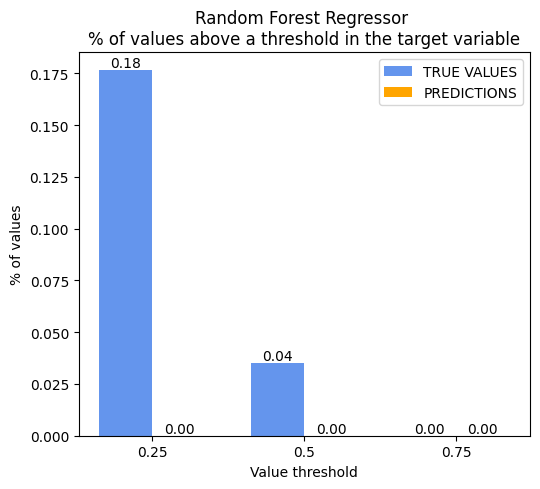

In [20]:
# Plotting difference in values above thresholds.
nr_values = y_test.shape[0] * y_test.shape[1]
print(f'Total number of values in target vectors: {nr_values}')

bar_width = 0.35

bar_positions1 = [x - bar_width / 2 for x in range(len(threshold_tuples))]
bar_positions2 = [x + bar_width / 2 for x in range(len(threshold_tuples))]

fig, ax = plt.subplots(figsize=(5.5,5))

ax.bar_label(plt.bar(bar_positions1, [t[0] for t in threshold_tuples], \
    width=bar_width, color='cornflowerblue', label='TRUE VALUES'), fmt='%.2f')
ax.bar_label(plt.bar(bar_positions2, [t[1] for t in threshold_tuples], \
    width=bar_width, color='orange', label='PREDICTIONS'), fmt='%.2f')

ax.set_xticks(range(len(threshold_tuples)), [str(th) for th in thresholds])

ax.set_xlabel('Value threshold')
ax.set_ylabel('% of values')
ax.set_title(f'Random Forest Regressor \n% of values above a threshold in the target variable')

ax.legend()

plt.tight_layout()

plt.savefig(f'./Figures/pilot_RF_values_above_threshold.png')

plt.show()

## Gradient boosting regressor

In [21]:
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Perform cross-validation to find the best hyperparameters
learning_rates = [0.1, 0.01, 0.001]
n_estimators = [i for i in range(50, 550, 100)]
max_depth = [None]
max_depth.extend([i for i in range(1, 11, 2)])

total_combinations = len(learning_rates) * len(n_estimators) * len(max_depth)
progress_counter = 0

best_score = float('inf')
best_n_estimators = None
best_max_depth = None

for rate in learning_rates:
    for est in n_estimators:
        for depth in max_depth:
            y_pred_cv = np.zeros_like(y_train)
            gb = GradientBoostingRegressor(learning_rate=rate, n_estimators=est, max_depth=depth, random_state=42, \
                                           validation_fraction=0.1, n_iter_no_change=10)

            for i in range(np.shape(y_train)[1]):
                y_pred_cv[:,i] = cross_val_predict(gb, X_train, y_train[:,i], cv=2, n_jobs=-1)
                
            # Apply modification to the predicted values based on X values
            for i in range(y_pred_cv.shape[0]):
                for j in range(X_train.shape[1]):
                    if j % 3 == 0:
                        if X_train[i, j] == 0:
                            y_pred_cv[i, j // 3] = noSupply_value

                        elif y_pred_cv[i, j // 3] < 0:
                            y_pred_cv[i, j // 3] = 0
                
            mean_score = mean_squared_error(y_train, y_pred_cv)
            
            if mean_score < best_score:
                best_score = mean_score
                best_rate = rate
                best_n_estimators = est
                best_max_depth = depth

            progress_counter += 1
            progress_percent = progress_counter / total_combinations * 100

            clear_output(wait=True)
            print(f'Progress: {progress_percent:.1f}%')

print('')
print(f'Learning rate: {best_rate}')
print(f'Number of trees: {best_n_estimators}')
print(f'Maximum tree depth: {best_max_depth}')
print(f'Mean squared error of best model: {best_score}')

Progress: 100.0%

Learning rate: 0.1
Number of trees: 50
Maximum tree depth: 1
Mean squared error of best model: 0.0006919545313686845


In [22]:
gb = GradientBoostingRegressor(learning_rate=best_rate, n_estimators=best_n_estimators, \
    max_depth=best_max_depth, random_state=23)

y_pred_test = np.zeros_like(y_test)

for j in range(np.shape(y_test)[1]):
    gb.fit(X_train, y_train[:,j])
    y_pred_test[:,j] = gb.predict(X_test)

    for i in range(y_pred_test.shape[0]):
            if X_test[i, j*3] == 0:
                    y_pred_test[i, j] = noSupply_value

            elif y_pred_test[i, j] < 0:
                y_pred_test[i, j] = 0

# Calculate prediction errors on the test set
errors = y_pred_test - y_test

# Report the desired metrics
min_error = np.min(errors)
max_error = np.max(errors)
mean_error = np.mean(np.abs(errors))
median_error = np.median(errors)
std_error = np.std(np.abs(errors))

print(f'Summary of errors for Gradient Boosting Regressor:')
print("Min Error:", min_error)
print("Max Error:", max_error)
print("Mean Error:", mean_error)
print("Median Error:", median_error)
print("Standard Deviation of Errors:", std_error)
print('')

Summary of errors for Gradient Boosting Regressor:
Min Error: -0.5928083485164701
Max Error: 0.3999128147350866
Mean Error: 0.0022167422180739966
Median Error: 3.64361768880478e-05
Standard Deviation of Errors: 0.01948525361774537



In [24]:
thresholds = [0.25, 0.5, 0.75]

nr_values = y_test.shape[0] * y_test.shape[1]

threshold_tuples = [(np.sum(y_test > th) / nr_values * 100, np.sum(y_pred_test > th) / nr_values * 100) for th in thresholds]

for i, th in enumerate(thresholds):
    print(f'Percentage of freshly browsed values above {th}:')
    print(f'TRUE DATA - PREDICTIONS')
    print(f'{threshold_tuples[i][0]:.2f} - {threshold_tuples[i][1]:.2f}', '\n')

Percentage of freshly browsed values above 0.25:
TRUE DATA - PREDICTIONS
0.18 - 0.05 

Percentage of freshly browsed values above 0.5:
TRUE DATA - PREDICTIONS
0.04 - 0.00 

Percentage of freshly browsed values above 0.75:
TRUE DATA - PREDICTIONS
0.00 - 0.00 



Total number of values in target vectors: 5670


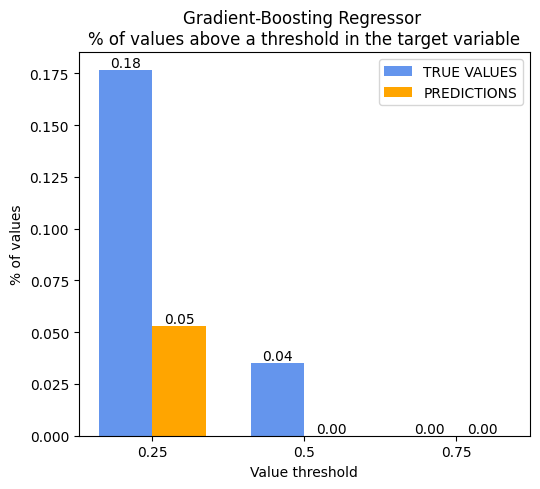

In [25]:
# Plotting difference in values above thresholds.
nr_values = y_test.shape[0] * y_test.shape[1]
print(f'Total number of values in target vectors: {nr_values}')

bar_width = 0.35

bar_positions1 = [x - bar_width / 2 for x in range(len(threshold_tuples))]
bar_positions2 = [x + bar_width / 2 for x in range(len(threshold_tuples))]

fig, ax = plt.subplots(figsize=(5.5,5))

ax.bar_label(plt.bar(bar_positions1, [t[0] for t in threshold_tuples], \
    width=bar_width, color='cornflowerblue', label='TRUE VALUES'), fmt='%.2f')
ax.bar_label(plt.bar(bar_positions2, [t[1] for t in threshold_tuples], \
    width=bar_width, color='orange', label='PREDICTIONS'), fmt='%.2f')

ax.set_xticks(range(len(threshold_tuples)), [str(th) for th in thresholds])

ax.set_xlabel('Value threshold')
ax.set_ylabel('% of values')
ax.set_title(f'Gradient-Boosting Regressor \n% of values above a threshold in the target variable')

ax.legend()

plt.tight_layout()

plt.savefig(f'./Figures/pilot_GB_values_above_threshold.png')

plt.show()

## Beta Regressor

In [26]:
class BetaRegressor(BaseEstimator, RegressorMixin):
    
    def __init__(self):
        self.model = None

    def fit(self, X, y):
        X_statsmodels = sm.add_constant(X)
        
        self.model = BetaModel(y, X_statsmodels)

        self.results = self.model.fit()

    def predict(self, X):
        X_statsmodels = sm.add_constant(X)
        
        return self.results.predict(X_statsmodels)

In [27]:
warnings.filterwarnings('ignore')

C_s = [i for i in range(1,11)]

total_combinations = len(C_s)

progress_counter = 0

# Exhanging ones to a value very close to 1 since beta regression cannot handle exactly 1.0 values.
y_train_beta = y_train.copy()
y_train_beta[y_train_beta == 1.0] = 1.0 - (-noSupply_value)

best_score = float('inf')

for C in C_s:
    y_pred_cv = np.zeros_like(y_train_beta)

    allZero = True

    for i in range(np.shape(y_train_beta)[1]):
        br = BetaRegressor()

        zi_br = ZeroInflatedRegressor(classifier=SVC(C=C), regressor=br)    

        # Using only columns where there IS supply from the species.
        y_train_reg_rows = [r for r in range(np.shape(y_train_beta)[0]) if y_train_beta[r, i] >= 0]
        y_train_noReg_rows = [r for r in range(np.shape(y_train_beta)[0]) if r not in y_train_reg_rows]

        X_train_reg = X_train[y_train_reg_rows]
        y_train_reg = y_train_beta[y_train_reg_rows, i]

        # Ensuring that there is at least one non-zero value in the target variable.
        y_train_reg[0] = -(-noSupply_value)

        try:        # Algorithm runs into error if all predicted targets are 0 by the classifier.
            y_pred_cv[y_train_reg_rows, i] = cross_val_predict(zi_br, X_train_reg, y_train_reg, cv=2)
            allZero = False

        except:
             pass        # Nothing to do as default prediction is 0.

        # Setting prediction for rows with no supply.
        y_pred_cv[y_train_noReg_rows, i] = noSupply_value

    # Importantly, the error is calculated with respect to the unmodified data.
    mean_score = mean_squared_error(y_train, y_pred_cv)

    if mean_score < best_score and allZero != True:     # Ensuring that the selected model does not classify all instances as 0 target.
        best_score = mean_score
        best_C = C

    progress_counter += 1
    progress_percent = progress_counter / total_combinations * 100

    clear_output(wait=True)
    print(f'Progress: {progress_percent:.1f}%')

print(f'Summary of cross validation for Zero-Inflated Beta Regressor:')
print(f'Classifier C value: {best_C}')

Progress: 100.0%
Summary of cross validation for Zero-Inflated Beta Regressor:
Classifier C value: 1


In [28]:
# Exchanging ones to a value very close to 1 since beta regression cannot handle exactly 1.0 values.
y_train_beta = y_train.copy()
y_train_beta[y_train_beta == 1.0] = 1.0 - (-noSupply_value)

y_test_beta = y_test.copy()
y_test_beta[y_test_beta == 1.0] = 1.0 - (-noSupply_value)

y_pred_test = np.zeros_like(y_test)

zi_br = ZeroInflatedRegressor(classifier=SVC(C=best_C), regressor=BetaRegressor())

for i in range(np.shape(y_test_beta)[1]):
        # Using only rows where there WAS supply from the species.
        reg_rows = [r for r in range(np.shape(y_test_beta)[0]) if y_test_beta[r, i] >= 0]
        noReg_rows = [r for r in range(np.shape(y_test_beta)[0]) if r not in reg_rows]

        X_train_reg = X_train[reg_rows]
        y_train_reg = y_train_beta[reg_rows, i]

        if len(y_train_reg) > 0:
                # Ensuring that there is at least one non-zero value in the target variable.
                y_train_reg[0] = -(-noSupply_value)
                
                X_test_reg = X_test[reg_rows]

                try:    # Runs into error if all target values are 0, so in that case, all predictions are set to 0.
                        zi_br.fit(X_train_reg, y_train_reg)
                        y_pred_test[reg_rows,i] = zi_br.predict(X_test_reg)

                except:
                        pass    # Nothing to do as default prediction is 0.

        # Setting prediction for rows with no supply.
        y_pred_test[noReg_rows, i] = noSupply_value

# Calculate prediction errors on the test set
errors = y_pred_test - y_test

# Report the desired metrics
min_error = np.min(errors)
max_error = np.max(errors)
mean_error = np.mean(np.abs(errors))
median_error = np.median(errors)
std_error = np.std(np.abs(errors))

print(f'Summary of errors for Zero-Inflated Beta Regressor:')
print("Min Error:", min_error)
print("Max Error:", max_error)
print("Mean Error:", mean_error)
print("Median Error:", median_error)
print("Standard Deviation of Errors:", std_error)
print('')

warnings.filterwarnings('default')

Summary of errors for Zero-Inflated Beta Regressor:
Min Error: -0.6666666666666666
Max Error: 0.0
Mean Error: 0.0011448498436958802
Median Error: 0.0
Standard Deviation of Errors: 0.02005993427445003



In [38]:
thresholds = [0.25, 0.5, 0.75]

nr_values = y_test.shape[0] * y_test.shape[1]

threshold_tuples = [(np.sum(y_test > th) / nr_values * 100, \
                     np.count_nonzero(np.logical_and(y_test > th, y_pred_test > th)) / nr_values * 100) \
                        for th in thresholds]

negative_tuple = (np.sum(y_test < 0) / nr_values * 100, np.sum(y_pred_test < 0) / nr_values * 100)

print(f'Percentage of negative predictions (i.e., due to no supply):')
print(f'TRUE DATA - PREDICTIONS')
print(f'{negative_tuple[0]:.2f} - {negative_tuple[1]:.2f}', '\n')

for i, th in enumerate(thresholds):
    print(f'Percentage of freshly browsed values above {th}:')
    print(f'TRUE DATA - PREDICTIONS')
    print(f'{threshold_tuples[i][0]:.2f} - {threshold_tuples[i][1]:.2f}', '\n')

Percentage of negative predictions (i.e., due to no supply):
TRUE DATA - PREDICTIONS
97.43 - 97.43 

Percentage of freshly browsed values above 0.25:
TRUE DATA - PREDICTIONS
0.18 - 0.00 

Percentage of freshly browsed values above 0.5:
TRUE DATA - PREDICTIONS
0.04 - 0.00 

Percentage of freshly browsed values above 0.75:
TRUE DATA - PREDICTIONS
0.00 - 0.00 



Total number of values in target vectors: 5670


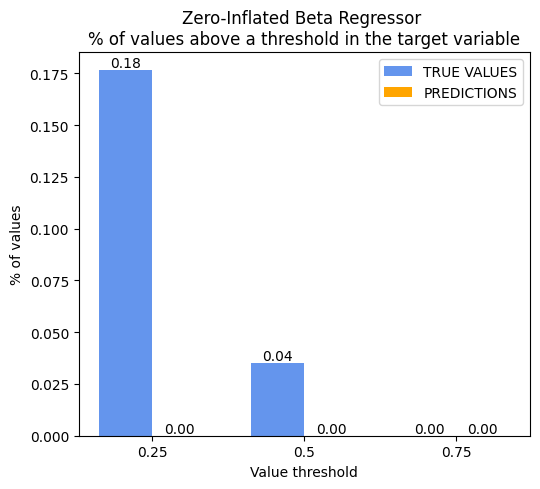

In [40]:
# Plotting difference in values above thresholds.
nr_values = y_test.shape[0] * y_test.shape[1]
print(f'Total number of values in target vectors: {nr_values}')

bar_width = 0.35

bar_positions1 = [x - bar_width / 2 for x in range(len(threshold_tuples))]
bar_positions2 = [x + bar_width / 2 for x in range(len(threshold_tuples))]

fig, ax = plt.subplots(figsize=(5.5,5))

ax.bar_label(plt.bar(bar_positions1, [t[0] for t in threshold_tuples], \
    width=bar_width, color='cornflowerblue', label='TRUE VALUES'), fmt='%.2f')
ax.bar_label(plt.bar(bar_positions2, [t[1] for t in threshold_tuples], \
    width=bar_width, color='orange', label='PREDICTIONS'), fmt='%.2f')

ax.set_xticks(range(len(threshold_tuples)), [str(th) for th in thresholds])

ax.set_xlabel('Value threshold')
ax.set_ylabel('% of values')
ax.set_title(f'Zero-Inflated Beta Regressor \n% of values above a threshold in the target variable')

ax.legend()

plt.tight_layout()

plt.savefig(f'./Figures/pilot_BR_values_above_threshold.png')

plt.show()